In [1]:
import matplotlib.pyplot as plt
import matplotlib
import numpy as np
from pytube import YouTube 
import os

import torch
import torchvision

In [2]:
from typing import Dict
import json
import urllib
from torchvision.transforms import Compose, Lambda
from torchvision.transforms._transforms_video import (
    CenterCropVideo,
    NormalizeVideo,
)
from pytorchvideo.data.encoded_video import EncodedVideo
from pytorchvideo.transforms import (
    ApplyTransformToKey,
    ShortSideScale,
    UniformTemporalSubsample,
    UniformCropVideo
) 

/share/kalanit/users/dfinzi/fit_venv/lib/python3.8/site-packages/torchvision/transforms/_functional_video.py:5: UserWarning: The _functional_video module is deprecated. Please use the functional module instead.
  warnings.warn(
/share/kalanit/users/dfinzi/fit_venv/lib/python3.8/site-packages/torchvision/transforms/_transforms_video.py:25: UserWarning: The _transforms_video module is deprecated. Please use the transforms module instead.
  warnings.warn(


In [3]:
import os 
os.environ["HDF5_USE_FILE_LOCKING"] = "FALSE"

## Test the SlowFast model on an example video clip

In [4]:
# Choose the `slowfast_r50` model 
model = torch.hub.load('facebookresearch/pytorchvideo', 'slowfast_r50', pretrained=True)

Using cache found in /share/kalanit/users/dfinzi/.cache/torch/hub/facebookresearch_pytorchvideo_main


In [5]:
# Set to GPU or CPU
device = "cpu"
model = model.eval()
model = model.to(device)

In [6]:
# Get classname info for kinetics
json_url = "https://dl.fbaipublicfiles.com/pyslowfast/dataset/class_names/kinetics_classnames.json"
json_filename = "kinetics_classnames.json"
try: urllib.URLopener().retrieve(json_url, json_filename)
except: urllib.request.urlretrieve(json_url, json_filename)
with open(json_filename, "r") as f:
    kinetics_classnames = json.load(f)

# Create an id to label name mapping
kinetics_id_to_classname = {}
for k, v in kinetics_classnames.items():
    kinetics_id_to_classname[v] = str(k).replace('"', "")

In [8]:
# Preprocessing pathway for images
side_size = 256
mean = [0.45, 0.45, 0.45]
std = [0.225, 0.225, 0.225]
crop_size = 256
num_frames = 32
sampling_rate = 2
frames_per_second = 30
slowfast_alpha = 4
num_clips = 10
num_crops = 3

class PackPathway(torch.nn.Module):
    """
    Transform for converting video frames as a list of tensors. 
    """
    def __init__(self):
        super().__init__()
        
    def forward(self, frames: torch.Tensor):
        fast_pathway = frames
        # Perform temporal sampling from the fast pathway.
        slow_pathway = torch.index_select(
            frames,
            1,
            torch.linspace(
                0, frames.shape[1] - 1, frames.shape[1] // slowfast_alpha
            ).long(),
        )
        frame_list = [slow_pathway, fast_pathway]
        return frame_list

transform =  ApplyTransformToKey(
    key="video",
    transform=Compose(
        [
            UniformTemporalSubsample(num_frames),
            Lambda(lambda x: x/255.0),
            NormalizeVideo(mean, std),
            ShortSideScale(
                size=side_size
            ),
            CenterCropVideo(crop_size),
            PackPathway()
        ]
    ),
)

# The duration of the input clip is also specific to the model.
clip_duration = (num_frames * sampling_rate)/frames_per_second

In [9]:
# Load example video clip
url_link = "https://dl.fbaipublicfiles.com/pytorchvideo/projects/archery.mp4"
video_path = 'archery.mp4'
try: urllib.URLopener().retrieve(url_link, video_path)
except: urllib.request.urlretrieve(url_link, video_path)
    
# Select the duration of the clip to load by specifying the start and end duration
# The start_sec should correspond to where the action occurs in the video
start_sec = 0
end_sec = start_sec + clip_duration

# Initialize an EncodedVideo helper class and load the video
video = EncodedVideo.from_path(video_path)

# Load the desired clip
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

In [10]:
video_data['video'].shape

torch.Size([3, 64, 240, 320])

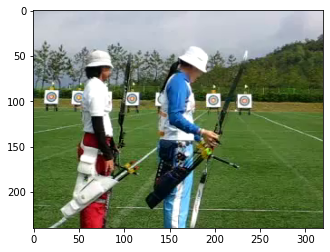

In [11]:
plt.imshow(video_data['video'][:,0,:,:].permute(1,2,0)/255) #first frame

In [12]:
# Apply a transform to normalize the video input
video_data = transform(video_data)

# Move the inputs to the desired device
inputs = video_data["video"]
inputs = [i.to(device)[None, ...] for i in inputs]

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([3, 8, 256, 256])


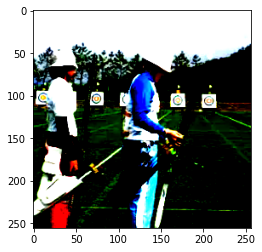

In [13]:
view = np.squeeze(inputs[0])
print(view.shape)

plt.imshow(view.permute(1, 2, 3, 0)[0])

In [14]:
print(inputs[0].shape) # slow pathway inputs
print(inputs[1].shape) # fast pathway inputs

torch.Size([1, 3, 8, 256, 256])
torch.Size([1, 3, 32, 256, 256])


In [15]:
# Run forward pass of the trained model (on our example video clip)
preds = model(inputs)

In [17]:
preds.shape

torch.Size([1, 400])

In [18]:
# Get the predicted classes
post_act = torch.nn.Softmax(dim=1)
preds = post_act(preds)
pred_classes = preds.topk(k=5).indices[0]

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: archery, throwing axe, playing paintball, disc golfing, riding or walking with horse


### Let's try again with a Kinetics test set video from youtube of our choice

In [21]:
# where to save 
SAVE_PATH = "~/oak_dtn/biac2/kgs/projects/Dawn/NSD/code/fit_pipeline/notebooks"
  
# link of the video to be downloaded 
link="https://www.youtube.com/watch?v=--0kKuQu4Gs"
  
try: 
    # object creation using YouTube
    # which was imported in the beginning 
    yt = YouTube(link) 
except: 
    print("Connection Error") #to handle exception 

out_file = yt.streams.filter(progressive=True, file_extension='mp4').order_by('resolution')[-1].download()
video_path = 'kinetics_test_vid.mp4'
os.rename(out_file, video_path)
  

In [22]:
start_sec = 0
end_sec = start_sec + clip_duration

video = EncodedVideo.from_path(video_path)
video_data = video.get_clip(start_sec=start_sec, end_sec=end_sec)

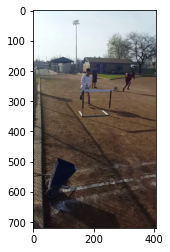

In [23]:
plt.imshow(video_data['video'][:,0,:,:].permute(1,2,0)/255) #first frame

In [24]:
# Apply a transform to normalize the video input
video_data = transform(video_data)

# Move the inputs to the desired device
clip2 = video_data["video"]
clip2 = [i.to(device)[None, ...] for i in clip2]

In [25]:
preds2 = model(clip2)
preds2 = post_act(preds2)
pred_classes = preds2.topk(k=5).indices[0]

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: hurdling, parkour, long jump, playing cricket, riding or walking with horse


## Making fake 'video' inputs from the NSD dataset

In [26]:
import sys

sys.path.append("..")
from paths import *
from datasets.nsd import nsd_dataloader

In [27]:
# Preprocess a chunk of the NSD stimuli
batch = nsd_dataloader(
    list(range(0,5)), video=True, batch_size=1 
)
dataiter = iter(batch)
first_nsd_example = dataiter.next()

In [28]:
print(first_nsd_example[0].shape) # slow inputs
print(first_nsd_example[1].shape) # fast inputs

torch.Size([1, 3, 8, 256, 256])
torch.Size([1, 3, 32, 256, 256])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


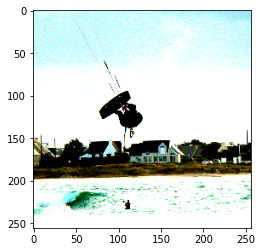

In [29]:
plt.imshow(first_nsd_example[0][0,:,0,:,:].permute(1,2,0)) #first "frame"

In [30]:
nsd_preds = model(first_nsd_example)
nsd_preds = post_act(nsd_preds)
pred_classes = nsd_preds.topk(k=5).indices[0]

# Map the predicted classes to the label names
pred_class_names = [kinetics_id_to_classname[int(i)] for i in pred_classes]
print("Top 5 predicted labels: %s" % ", ".join(pred_class_names))

Top 5 predicted labels: kitesurfing, swinging on something, snowkiting, windsurfing, surfing water


### Let's visualize the filters for the first conv layer for each pathway

In [40]:
# model structures
for name, layer in model.named_modules():
    print(name)


blocks
blocks.0
blocks.0.multipathway_blocks
blocks.0.multipathway_blocks.0
blocks.0.multipathway_blocks.0.conv
blocks.0.multipathway_blocks.0.norm
blocks.0.multipathway_blocks.0.activation
blocks.0.multipathway_blocks.0.pool
blocks.0.multipathway_blocks.1
blocks.0.multipathway_blocks.1.conv
blocks.0.multipathway_blocks.1.norm
blocks.0.multipathway_blocks.1.activation
blocks.0.multipathway_blocks.1.pool
blocks.0.multipathway_fusion
blocks.0.multipathway_fusion.conv_fast_to_slow
blocks.0.multipathway_fusion.norm
blocks.0.multipathway_fusion.activation
blocks.1
blocks.1.multipathway_blocks
blocks.1.multipathway_blocks.0
blocks.1.multipathway_blocks.0.res_blocks
blocks.1.multipathway_blocks.0.res_blocks.0
blocks.1.multipathway_blocks.0.res_blocks.0.branch1_conv
blocks.1.multipathway_blocks.0.res_blocks.0.branch1_norm
blocks.1.multipathway_blocks.0.res_blocks.0.branch2
blocks.1.multipathway_blocks.0.res_blocks.0.branch2.conv_a
blocks.1.multipathway_blocks.0.res_blocks.0.branch2.norm_a
blo

In [31]:
model.blocks[1].multipathway_blocks[1].res_blocks[0].branch2.conv_b.weight.detach().clone().shape

torch.Size([8, 8, 1, 3, 3])

In [33]:
first_conv_slow_filters = model.blocks[0].multipathway_blocks[0].conv.weight.detach().clone()

In [34]:
first_conv_slow_filters.shape

torch.Size([64, 3, 1, 7, 7])

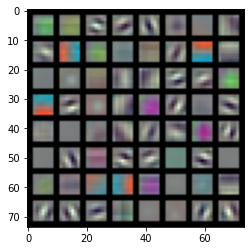

In [35]:
kernels = torch.squeeze(first_conv_slow_filters)
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()
filter_img = torchvision.utils.make_grid(kernels, nrow = 8)

plt.imshow(filter_img.permute(1, 2, 0))

In [36]:
first_conv_fast_filters = model.blocks[0].multipathway_blocks[1].conv.weight.detach().clone()

In [37]:
first_conv_fast_filters.shape

torch.Size([8, 3, 5, 7, 7])

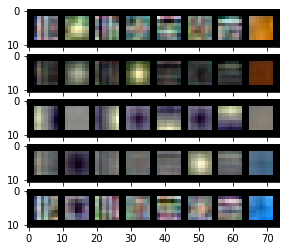

In [38]:
for i in range(5):
    kernels = torch.squeeze(first_conv_fast_filters[:,:,i,:,:]) #ignore temporal dimension, just pick first temporal feature set
    kernels = kernels - kernels.min()
    kernels = kernels / kernels.max()
    filter_img = torchvision.utils.make_grid(kernels)
    
    plt.subplot(5, 1, i+1)
    plt.imshow(filter_img.permute(1, 2, 0))


In [ ]:
# replot with x vs t and y vs t and c vs t
# devalois 1999 pnas paper
# conway & livingstone 2003
# to look at the derivatives

<IPython.core.display.Javascript object>


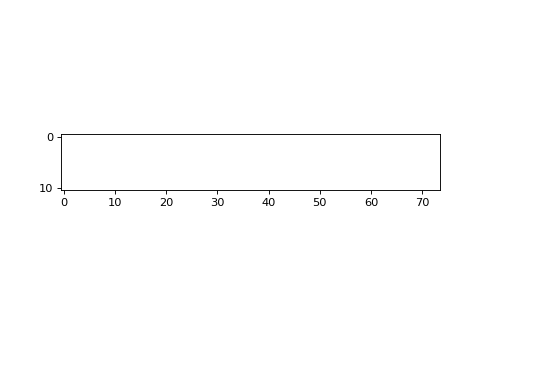

In [90]:
import matplotlib.animation as animation
# need this line if you're using jupyter notebooks
%matplotlib notebook
plt.ion()

kernels = first_conv_fast_filters
kernels = kernels - kernels.min()
kernels = kernels / kernels.max()

frames = [] # for storing the generated images
fig = plt.figure()
for i in range(5):
    img = torchvision.utils.make_grid(torch.squeeze(kernels[:,:,i,:,:]))
    frames.append([plt.imshow(img.permute(1,2,0), animated=True)])

ani = animation.ArtistAnimation(fig, frames, interval=500, blit=True, repeat_delay = 1000)
# ani.save('movie.mp4')
plt.show()
